# Dependencies

## Optional: GDrive connection
If you want to run this on Google Colab, you can connect the notebook to your Google Drive to access training data from there. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Libraries and Parameters

In [34]:
import torch
import torch.nn as nn
import mmap
import time
import random
import pickle
from torchinfo import summary
import matplotlib.pyplot as plt

source_data_path = "./"
source_data = "text.txt"
model_export = "model.pth"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

device = "mps" if torch.backends.mps.is_available() else device

print(f'Running on `{device}`')

batch_size = 8 # how many blocks per batch
block_size = 8 # length of sequence of tokens, how many chars per block
epochs = 1000
learning_rate = 0.0001
embedding_size = 128 # the size of the embedding vectors that each token will be assigned to, like if A = 1, 1 would be encoded to a vector of size 128
num_blocks = 4 # amount of blocks
num_heads = 4 # amount of heads per blocks, should be bigger as embedding_size, see next line
head_size = embedding_size // num_heads # dont change this, defining it here for better readability
dropout_rate = 0.2 # how many nodes to drop per each epoch
hidden_units_factor = 4 # how many hidden units for the sequential layer stack, using a factor here, multiplied with embedding_size
train_split = 0.8

losses = {}

Running on `mps`


## Data
I am giving you two options here: Either create a dummy data set with a lot of simple repetitions. This allows the model to learn fast. Or choose a real world example.

For this I am using a very **very small dataset** only, as this is for training purposes only. If you are looking for better results, you may refer to e.g. **OpenWebText** or other available data sets. 

We are going to read the data and split it into two parts: **Training** data and **testing** data. 

Next we get a list of all used `chars` and create two tables for encoding and decoding(`char_table` and `reverse_char_table`) text into vector of integers. The `vocab_size` shows the amount of different chars in the text.

### Dummy Data

In [26]:
sentence = "Hello World! Hello World! Hello World! \n"
sentence = "ABA\n"
f_dummy_data = open(f"{source_data_path}/text.txt", 'w')
f_dummy_data.write(sentence * 1000)
f_dummy_data.close()

### Prepare

In [27]:
chars = ""
full_text = []
source_data_train = f"train_{source_data}"
source_data_test = f"test_{source_data}"

f_full_text = open(f"{source_data_path}/{source_data}", "r")
f_training_text = open(f"{source_data_path}/{source_data_train}", 'w')
f_test_test = open(f"{source_data_path}/{source_data_test}", 'w')

for line in f_full_text:
  r = random.random()
  full_text.append(line)
  if (0.0 <=  r <= train_split):
    f_training_text.write(line)
  else:
    f_test_test.write(line)

f_full_text.close()
f_training_text.close()
f_test_test.close()

chars = sorted(list(set(' '.join(full_text))))
char_table = {char:index for index,char in enumerate(chars)}
reverse_char_table = {index:char for index,char in enumerate(char_table)}

vocab_size = len(chars)
del full_text

print(f'Vocabulary size is {vocab_size}')

Vocabulary size is 4


## Helper Functions

We will create four functions:
`encode()` and `decode()` will allow us to convert text to a vector of integers and back. 

`get_batch` and `get_random_chunk` will randomly read text chunks from our **training** and **testing** data set.

In [28]:
def encode(char_table: list, text: str = None):
  return [char_table[char] for char in text]

def decode(char_table: list, numbers: list = []):
  return ''.join([char_table[index] for index in numbers])

# memory map for using small snippets of text from a single file of any size
def get_random_chunk(split):
    filename = f"{source_data_path}/{source_data_train}" if split == 'train' else f"{source_data_path}/{source_data_test}"
    with open(filename, 'r') as f:
        with mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ) as mm:
            # Determine the file size and a random position to start reading
            file_size = len(mm)
            start_pos = random.randint(0, (file_size) - block_size * batch_size)

            # Seek to the random position and read data binary
            mm.seek(start_pos)
            raw_data = mm.read(block_size * batch_size - 1)

            # Decode the block to a string, ignoring any invalid byte sequences
            data = raw_data.decode('utf-8', errors='ignore').replace('\r', '')

            # encode to torch tensor using char table
            encoded_data = torch.tensor(encode(char_table = char_table, text = data), dtype=torch.long)

    return encoded_data


def get_batch(split):
    
    encoded_data = get_random_chunk(split)
    random_block_start_indices = torch.randint(len(encoded_data) - block_size, (batch_size,))

    input_sequences = torch.stack([encoded_data[index:index + block_size] for index in random_block_start_indices])
    target_sequences = torch.stack([encoded_data[index + 1:index + block_size + 1] for index in random_block_start_indices])

    return input_sequences.to(device), target_sequences.to(device)

The following part just tests encoding and decoding feature:

In [29]:
char_table

{'\n': 0, ' ': 1, 'A': 2, 'B': 3}

In [30]:
text = 'Hello World!'
encoded_text = encode(char_table, 'Hello World!')
decoded_text = decode(reverse_char_table, encoded_text)
print(f'Encoding `{text} ` to  `{encoded_text} ` and back to  `{decoded_text} `')

KeyError: 'H'

## Model Classes
This part defines the model structure. I am referring to the Multi-Head attention approach. I am not going into detail about mathematics. 

This is the comprised structure:

- create **token** and **position embeddings** of the input text and pass them to
- a sequential layer stack of `num_blocks` blocks 
  - pass embeddings to one **MultiHeadAttention** per block consisting of `num_heads` of heads for **self-attention calculation**
    - pass result to a linear **projection layer**
    - apply dropout of `dropout_rate` nodes 
  - pass results to the first **normalisation layer**
  - pass results to a **feed forward layer**, which consists of a sequential layer stack of
    - a linear layer
    - a non-linear ReLU layer
    - a linear layer
    - another dropout layer
  - pass results to the second **normalisation layer**
- pass results to another **normalisation layer**
- pass results to a final **linear layer**
- reset the weights

In [235]:
class Head(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.linear_layer_keys = nn.Linear(in_features=embedding_size, out_features=head_size, bias=False)
        self.linear_layer_queries = nn.Linear(in_features=embedding_size, out_features=head_size, bias=False)
        self.linear_layer_values = nn.Linear(in_features=embedding_size, out_features=head_size, bias=False)
        
        # lower triangular matrix
        # .register_buffer register "not trainable parameters" for the model
        # .tril() takes a tensor and changes all values above a diagonal (top left to bottom right) to 0
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size))) 

        # forget nodes
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, X_embeddings):
        
        # input shape (batch_size, sequence_length (time steps), number of features (channels))
        # output shape (batch_size, sequence_length (time steps), head_size)
            
        keys = self.linear_layer_keys(X_embeddings)
        queries = self.linear_layer_queries(X_embeddings)
        
        # compute attention scores ("affinities")
        
        # the core of this model: the attention mechanism
        # scaled dot product attention by matrix multiplication and scaling the result using square root of the head_size
        # we could either divide by square root of head size or multiple by inverse square root of head size, result is the same
        scaled_attention_scores = queries @ keys.transpose(-2,-1) * keys.shape[-1] ** -0.5
        
        # "sort out" all the weights above the diagonale to make sure a token depends/attends on/to previous tokens
        causal_attention_scores = scaled_attention_scores.masked_fill(self.tril[:block_size, :block_size] == 0, float('-inf'))
        
        # normalize probabilities
        weights = torch.softmax(causal_attention_scores, dim=-1)
        
        # forget some weights
        weights = self.dropout(weights)

        # perform the weighted aggregation of the values
        values = self.linear_layer_values(X_embeddings)
        weighted_values = weights @ values
        return weighted_values

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self):
        super().__init__()
        
        self.heads = nn.ModuleList([Head() for head in range(num_heads)])
        self.projections = nn.Linear(head_size * num_heads, embedding_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, X_embeddings):
        weighted_values = torch.cat([head(X_embeddings) for head in self.heads], dim=-1) 
        weighted_values = self.dropout(self.projections(weighted_values))
        return weighted_values

class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features = embedding_size, out_features = hidden_units_factor * embedding_size),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units_factor * embedding_size, out_features = embedding_size),
            nn.Dropout(dropout_rate),
        )

    def forward(self, X):
        return self.linear_layer_stack(X)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self):
        super().__init__()
        
        self.self_attention_layer = MultiHeadAttention()
        self.normalisation_layer_1 = nn.LayerNorm(embedding_size)
        
        self.feed_forward_layer = FeedForward(embedding_size)
        self.normalisation_layer_2 = nn.LayerNorm(embedding_size)

    def forward(self, X_embeddings):
        
        y = self.self_attention_layer(X_embeddings)
        X_embeddings = self.normalisation_layer_1(X_embeddings + y)
        
        y = self.feed_forward_layer(X_embeddings)
        X_embeddings = self.normalisation_layer_2(X_embeddings + y)
        
        return X_embeddings

class GPTLanguageModel(nn.Module):
    
    def __init__(self, vocab_size):
        super().__init__()
        
        self.token_embedding_table = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_size)
        self.position_embedding_table = nn.Embedding(num_embeddings=block_size, embedding_dim=embedding_size)
        
        self.blocks = nn.Sequential(*[Block() for layer in range(num_blocks)])
        self.normalisation_layer = nn.LayerNorm(embedding_size)
        self.final_layer = nn.Linear(embedding_size, vocab_size)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, X_batch):
        # X_batch - a batch of blocks (aka sequences), each containing chars

        # from a simple encoding like [0] (for `A`) to an embedding vector where each token is represented by it's own vector of size "embedding_size" like [0.0265, 0.0334]
        X_token_embeddings = self.token_embedding_table(X_batch) 
        
        # block_size - Block Size/Time Steps - how many chars within a block (aka sequence)
        X_position_embeddings = self.position_embedding_table(torch.arange(block_size, device = device))
        
        X_embeddings = X_token_embeddings + X_position_embeddings
        
        labels = self.blocks(X_embeddings) # (B,T,C)
        labels = self.normalisation_layer(labels) # (B,T,C)
        labels = self.final_layer(labels) # (Batch Size, Block Size, Vocab Size)

        return labels

    def generate(self, context, max_new_tokens):
        # context is encoded prompt as a tensor of floats with shape = (Batch Size, Block Size Dummy) 
        for new_token in range(max_new_tokens):
            # get block from context
            block = context[:, -block_size:]
            # let the model calculate prediction logits
            y_logits = self.forward(block)
            # focus only on the last time step
            y_logits = y_logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            y_prediction_probs = torch.softmax(y_logits, dim=-1) # (B, C)
            # sample from the distribution
            y_predicted = torch.multinomial(y_prediction_probs, num_samples=1) # (B, 1)
            # append predicted label to the sequence
            context = torch.cat((context, y_predicted), dim=1) # (B, T+1)
        return context

# Training process
## Init the model
This is where the preparation ends. We are ready to **init** our model. 

We are using the **AdamW optimizier** and the common **cross entropy** loss function. 

If you want to start over, do it here:

In [36]:
model = GPTLanguageModel(vocab_size)

model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

losses = {
    'epoch': [],
    'loss_train': [],
    'loss_test': [],
    'duration': 0 # seconds
}

## Training loop
Now we are ready to start the trainign and test loop. I am referring to the suggested approach by Daniel Bourke (checkout his "*Optimization loop song*: https://www.youtube.com/watch?v=Nutpusq_AFw).

This is the rough architecture behind the loop:

- get a fresh and random batch of data
- pass training data (`features_train`) to the model
- calculate the loss by comparing the predicted results `labels_logits`to the expected results `labels_traing`
- zero grad the optimizer
- do back propagation of the loss
- update parameters via optimizer function
- start testing in torch's inference mode
- calclate the test los by comparing the predicted test results `labels_logits` to the expected test results `labels_test`

We will record train and test losses to plot them later.

In [37]:
print(f"Device: {device}\nBatch Size: {batch_size}\nBlock Size: {block_size}\nEpochs: {epochs}\nLearning Rate: {learning_rate}\n"
      f"Embeddings: {embedding_size}\Blocks: {num_blocks}\nHeads: {num_heads}\n"
      f"Dropout Rate: {dropout_rate}\nHidden Units Factor: {hidden_units_factor}\nTrain/Test Split: {train_split}\n--\n")

start = time.time()

start_epoch = 0 if len(losses['epoch']) == 0 else losses['epoch'][-1]

for epoch in range(start_epoch, start_epoch + epochs):

    # TRAIN
    model.train()

    # GET BATCH OF TRAINING DATA
    # ALREADY CONTAINS CHAR-ENCODED TEXT LIKE `3, 6, 7, 7, 8` for `HELLO`
    X_train, y_train = get_batch('train')
    # PREDICTIONS
    labels_logits = model(X_train)

    # LOSS
    curr_batches, curr_blocks, curr_classes = labels_logits.shape
    labels_logits = labels_logits.view(curr_batches * curr_blocks, curr_classes) # merge Batches to one single batch, also keep number of classes
    y_train = y_train.view(curr_batches * curr_blocks) # merge Batches to one single batch, no classes required for cross_entropy
    loss_train = loss_fn(labels_logits, y_train)

    # SET OPTIMIZER TO ZERO
    optimizer.zero_grad(set_to_none=True)
    
    # BACK PROPAGATION 
    loss_train.backward()

    # UPDATE PARAMETERS
    optimizer.step()

    # LOG
    if epochs < 10 or epoch % int(epochs / 10) == 0:

      # TEST  
      model.eval()
      with torch.inference_mode():
        features_test, labels_test = get_batch('test')
        labels_logits = model(features_test)
        curr_batches, curr_blocks, curr_classes = labels_logits.shape
        labels_logits = labels_logits.view(curr_batches * curr_blocks, curr_classes) # merge Batches to one single batch, also keep number of classes
        labels_test = labels_test.view(curr_batches * curr_blocks) # merge Batches to one single batch, no classes required for cross_entropy
        loss_test = loss_fn(labels_logits, labels_test)

      print(f"Epoch {epoch} | Train loss {loss_train:.2f} | Test Loss {loss_test:.2f}")
      
      losses['epoch'].append(epoch)
      losses['loss_train'].append(loss_train.cpu().item())
      losses['loss_test'].append(loss_test.cpu().item())
      losses['duration'] += (time.time() - start)


Device: mps
Batch Size: 8
Block Size: 8
Epochs: 1000
Learning Rate: 0.0001
Embeddings: 128\Blocks: 4
Heads: 4
Dropout Rate: 0.2
Hidden Units Factor: 4
Train/Test Split: 0.8
--

Parameter containing:
tensor([[ 0.0152,  0.0101,  0.0005,  ...,  0.0024, -0.0027, -0.0063],
        [-0.0203,  0.0003, -0.0061,  ..., -0.0117, -0.0171,  0.0126],
        [ 0.0157,  0.0207,  0.0206,  ...,  0.0077,  0.0059, -0.0419],
        ...,
        [ 0.0335,  0.0315, -0.0021,  ...,  0.0176,  0.0284,  0.0229],
        [ 0.0066, -0.0229,  0.0170,  ...,  0.0095,  0.0187, -0.0057],
        [-0.0014,  0.0187, -0.0018,  ...,  0.0013,  0.0130,  0.0494]],
       device='mps:0', requires_grad=True)
Parameter containing:
tensor([[ 0.0152,  0.0101,  0.0005,  ...,  0.0024, -0.0027, -0.0063],
        [-0.0203,  0.0003, -0.0061,  ..., -0.0117, -0.0171,  0.0126],
        [ 0.0157,  0.0207,  0.0206,  ...,  0.0077,  0.0059, -0.0419],
        ...,
        [ 0.0335,  0.0315, -0.0021,  ...,  0.0176,  0.0284,  0.0229],
        [

NameError: name 'sys' is not defined

## Plot results
We will plot train and test losses for each epoch to see how the loss goes down - hopefully.

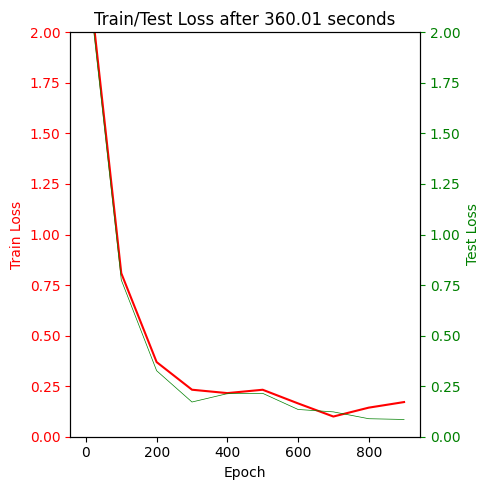

In [20]:
fig, ax1 = plt.subplots(figsize=(5, 5))
fontsize = 10
line_width = 0.5
y_axis_limit = int(max(losses['loss_train'] + losses['loss_test']) * 1.25)

ax1.plot(losses['epoch'], losses['loss_train'], color='red', label='Train Loss', linewidth=line_width + 1)
ax1.set_xlabel('Epoch', fontsize=fontsize)
ax1.set_ylabel('Train Loss', color='red', fontsize=fontsize)
ax1.tick_params('y', colors='red', labelsize=fontsize)
ax1.set_ylim(0, y_axis_limit) 

ax2 = ax1.twinx()
ax2.plot(losses['epoch'], losses['loss_test'], color='green', label='Test Loss', linewidth=line_width)
ax2.set_ylabel('Test Loss', color='green', fontsize=fontsize)
ax2.tick_params('y', colors='green', labelsize=fontsize)
ax2.set_ylim(0, y_axis_limit) 

plt.title(f'Train/Test Loss after {(losses["duration"]):.2f} seconds')
fig.tight_layout()
plt.show()

# Aftermath
## Loading and saving the model

We can utilize two functions to persist the model's result
- either putting everything to a pickel file or
- using PyTorch's state dic export feature

torch.save(obj = model.state_dict(), f = model_export)

In [32]:
model = GPTLanguageModel()
model.load_state_dict(torch.load(model_export))
model.to(device)

TypeError: __init__() missing 1 required positional argument: 'vocab_size'

In [ ]:
with open('model-01.pkl', 'wb') as f:
    pickle.dump(model, f)
print('model saved')

In [ ]:
with open('model-01.pkl', 'rb') as f:
     model = pickle.load(f)

# Use the model
Finally, apparently, we want to use the model. This simply generates new tokens for a given prompt.

In [21]:
prompt = 'H'
context = torch.tensor(encode(char_table, prompt), dtype=torch.long, device=device)

with torch.inference_mode():
  for iter in range(10):    
    generated_chars = decode(reverse_char_table, model.generate(context.unsqueeze(0), max_new_tokens = 30)[0].tolist())
    print(generated_chars)

Hello World! Hllo World! Hello 
Hello World! Hello Wold! 
Hello
Hello World! 
Hello World! 
Hel
Hello World! Hello World! 
Hell
Hello World! Hel
Hello World! H
Hellorld! eld! Hello World! 
He
Hello World! 
Hello World! 
Hel
Hello World! 
Hello World! ! He
Hello World! Hello World! 
Hell
Hello Wrld! Hello World! Hello 


# Step By Step

We will use a simple *text* containing 100 times the same chars: *ABCA*. First we need to encode it, simply using an integer char table.

In [158]:
data = 'ABCA' * 100

chars = sorted(list(set(''.join(data))))
vocab_size = len(chars)
char_table = {char:index for index,char in enumerate(chars)}
encoded_data = torch.tensor(encode(char_table = char_table, text = data), dtype=torch.long)

print(f'First 20 chars in our dataset: {data[:20]}')
print(f'Char table: {char_table}')
print(f'Vocabulary size is: {vocab_size}')

First 20 chars in our dataset: ABCAABCAABCAABCAABCA
Char table: {'A': 0, 'B': 1, 'C': 2}
Vocabulary size is: 3


Now we will take ```batch_size``` sequences of length ```block_size``` from random positions in text, in this case **2 blocks** with a length of **4 chars** each:

In [166]:
block_size = 4 # tokens per block/sequence
batch_size = 2 # blocks per batch

random_block_start_indices = torch.randint(len(encoded_data) - block_size, (batch_size,))
            
X_batch = torch.stack([encoded_data[index:index + block_size] for index in random_block_start_indices])
X_batch = X_batch.to(device)
X_batch

tensor([[0, 1, 2, 0],
        [0, 0, 1, 2]], device='mps:0')

This gives us a batch of blocks (or sequences) that we can use for training. 
We could translate this back to readable chars:

In [167]:
print([''.join(list(char_table.keys())[idx] for idx in sequence) for sequence in X_batch.cpu().numpy()])

['ABCA', 'AABC']


In [169]:
embedding_size = 3

token_embeddings_table = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_size).to(device)
X_token_embeddings = token_embeddings_table(X_batch)
X_token_embeddings

tensor([[[ 1.7042,  0.7347,  0.1688],
         [ 0.1699, -0.4541, -1.7925],
         [-0.1837, -0.4113, -1.7933],
         [ 1.7042,  0.7347,  0.1688]],

        [[ 1.7042,  0.7347,  0.1688],
         [ 1.7042,  0.7347,  0.1688],
         [ 0.1699, -0.4541, -1.7925],
         [-0.1837, -0.4113, -1.7933]]], device='mps:0',
       grad_fn=<EmbeddingBackward0>)

In [197]:
position_embeddings_table = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_size).to(device)
positions = torch.arange(block_size, device = device)
positions

tensor([0, 1, 2, 3], device='mps:0')

In [199]:
X_position_embeddings = position_embeddings_table(positions)
X_position_embeddings

tensor([[-0.8644, -0.6244,  1.1936],
        [ 1.8613,  1.4914, -1.2505],
        [-0.3755, -0.2110,  0.7012],
        [ 0.0000,  0.0000,  0.0000]], device='mps:0',
       grad_fn=<EmbeddingBackward0>)

In [191]:
X_embeddings = X_token_embeddings + X_position_embeddings
X_embeddings

tensor([[[ 0.8821,  1.9137,  1.6605],
         [ 0.1674,  0.3899, -1.0054],
         [-0.7229,  0.5058, -3.5047],
         [ 1.7042,  0.7347,  0.1688]],

        [[ 0.8821,  1.9137,  1.6605],
         [ 1.7017,  1.5787,  0.9559],
         [-0.3693,  0.4630, -3.5038],
         [-0.1837, -0.4113, -1.7933]]], device='mps:0', grad_fn=<AddBackward0>)

Now we'll send our embeddings through the Block-Class and a the MultiHeadAttention-Class to the Head-Class where we first calculate our ```keys``` and ```queries``` using a *Linear Layer*:

In [230]:
# this is for training purposes, if we had multiple heads, we'd set this to embedding_size / num_heads, now every token is represented by
# one scalar value only, which does not really make sense
head_size = 1 

linear_layer_keys = nn.Linear(in_features=embedding_size, out_features=head_size, bias=False).to(device)
linear_layer_queries = nn.Linear(in_features=embedding_size, out_features=head_size, bias=False).to(device)
keys = linear_layer_keys(X_embeddings)
queries = linear_layer_queries(X_embeddings)
print(keys)
print(queries)


tensor([[[-0.5929],
         [ 0.5622],
         [ 1.9725],
         [-0.1752]],

        [[-0.5929],
         [-0.4113],
         [ 1.9159],
         [ 0.8550]]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[[-0.1706],
         [-0.2536],
         [-0.5840],
         [-0.2957]],

        [[-0.1706],
         [-0.3180],
         [-0.6159],
         [-0.1994]]], device='mps:0', grad_fn=<LinearBackward0>)


In [232]:
scaled_attention_scores = queries @ keys.transpose(-2,-1) * keys.shape[-1] ** -0.5
scaled_attention_scores

tensor([[[ 0.1012, -0.0959, -0.3366,  0.0299],
         [ 0.1504, -0.1426, -0.5002,  0.0444],
         [ 0.3463, -0.3283, -1.1520,  0.1023],
         [ 0.1753, -0.1662, -0.5833,  0.0518]],

        [[ 0.1012,  0.0702, -0.3269, -0.1459],
         [ 0.1886,  0.1308, -0.6093, -0.2719],
         [ 0.3652,  0.2533, -1.1800, -0.5266],
         [ 0.1182,  0.0820, -0.3821, -0.1705]]], device='mps:0',
       grad_fn=<MulBackward0>)

In [237]:
# "sort out" all the weights above the diagonale to make sure a token depends/attends on/to previous tokens
triangular_matrix= torch.tril(torch.ones(block_size, block_size)).to(device)
triangular_matrix

tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]], device='mps:0')

In [238]:
causal_attention_scores = scaled_attention_scores.masked_fill(triangular_matrix[:block_size, :block_size] == 0, float('-inf'))
causal_attention_scores

tensor([[[ 0.1012,    -inf,    -inf,    -inf],
         [ 0.1504, -0.1426,    -inf,    -inf],
         [ 0.3463, -0.3283, -1.1520,    -inf],
         [ 0.1753, -0.1662, -0.5833,  0.0518]],

        [[ 0.1012,    -inf,    -inf,    -inf],
         [ 0.1886,  0.1308,    -inf,    -inf],
         [ 0.3652,  0.2533, -1.1800,    -inf],
         [ 0.1182,  0.0820, -0.3821, -0.1705]]], device='mps:0',
       grad_fn=<MaskedFillBackward0>)

In [239]:
# normalize probabilities
weights = torch.softmax(causal_attention_scores, dim=-1) # (B, T, T)
weights

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.5727, 0.4273, 0.0000, 0.0000],
         [0.5771, 0.2939, 0.1290, 0.0000],
         [0.3265, 0.2320, 0.1529, 0.2886]],

        [[1.0000, 0.0000, 0.0000, 0.0000],
         [0.5144, 0.4856, 0.0000, 0.0000],
         [0.4745, 0.4243, 0.1012, 0.0000],
         [0.3012, 0.2905, 0.1826, 0.2257]]], device='mps:0',
       grad_fn=<SoftmaxBackward0>)

In [244]:
dropout_rate = 0.2 # how many nodes to drop per each epoch

# forget some weights
dropout = nn.Dropout(dropout_rate)
weights = dropout(weights)
weights

tensor([[[0.0000, 0.0000, 0.0000, 0.0000],
         [0.7159, 0.5341, 0.0000, 0.0000],
         [0.7213, 0.3674, 0.1612, 0.0000],
         [0.4081, 0.2900, 0.1911, 0.3607]],

        [[1.2500, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.6070, 0.0000, 0.0000],
         [0.5931, 0.5304, 0.0000, 0.0000],
         [0.3765, 0.3631, 0.2283, 0.2821]]], device='mps:0',
       grad_fn=<MulBackward0>)

In [245]:
linear_layer_values = nn.Linear(in_features=embedding_size, out_features=head_size, bias=False).to(device)
values = linear_layer_values(X_embeddings)
weighted_values = weights @ values
weighted_values

tensor([[[ 0.0000],
         [ 0.1185],
         [ 0.0589],
         [-0.2447]],

        [[ 0.5004],
         [-0.0981],
         [ 0.1517],
         [-0.2473]]], device='mps:0', grad_fn=<UnsafeViewBackward0>)

In the next step, within the MultiHeadAttention-Class, the weighted values of each head will now be concatenated and another dropout will be applied. We can skip this, as we only simulate one head here. The final result will be send back to the Block-Class, where it will be processed further. First step is a Normalisation Layer:

In [ ]:
normalisation_layer_1 = nn.LayerNorm(weighted_values)
X_embeddings = normalisation_layer_1(X_embeddings + y)

In [ ]:
feed_forward_layer = FeedForward(embedding_size)
self.normalisation_layer_2 = nn.LayerNorm(embedding_size)

def forward(self, X_embeddings):

y = self.self_attention_layer(X_embeddings)
y = self.feed_forward_layer(X_embeddings)
X_embeddings = self.normalisation_layer_2(X_embeddings + y)
